<a href="https://colab.research.google.com/github/JohannesKarwou/notebooks/blob/main/freeSolvSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy, os
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
sns.set_theme(
    style="white",
    rc={
        "figure.figsize": (12, 12),
        "axes.unicode_minus": False,
        "axes.labelsize": 30.0,
        "font.size": 65,
        "legend.fontsize": 25,
        "lines.markersize": 20,
        "xtick.labelsize": 30,
        "ytick.labelsize": 30,
        "xtick.bottom": True,
        "xtick.direction": "in",
        "ytick.left": True,
        "ytick.direction": "in",
    },
)

In [3]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/freeSolvCGenFF.csv"
)

In [4]:
def plotting_grey_area(i, one_plot=False):
    # shaded grey area
    if one_plot:
        x = np.linspace(-30, 20, 5)
        y = x
        axs.plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
        y2 = x + 1
        axs.plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
        y3 = x - 1
        axs.plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
        axs.fill_between(x, y2, y3, alpha=0.3, color="Grey")

        x = np.linspace(-30, 20, 5)
        y = x
        axs.plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
        y2 = x + 2
        axs.plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
        y3 = x - 2
        axs.plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
        axs.fill_between(x, y2, y3, alpha=0.3, color="Grey")
    else:
        x = np.linspace(-30, 20, 5)
        y = x
        axs[i].plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
        y2 = x + 1
        axs[i].plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
        y3 = x - 1
        axs[i].plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
        axs[i].fill_between(x, y2, y3, alpha=0.3, color="Grey")

        x = np.linspace(-30, 20, 5)
        y = x
        axs[i].plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
        y2 = x + 2
        axs[i].plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
        y3 = x - 2
        axs[i].plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
        axs[i].fill_between(x, y2, y3, alpha=0.3, color="Grey")

In [5]:
def bootstrap_metric(fct, x_values, y_values, p_value=False):
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices = np.random.choice(
            range(0, len(x_values)), size=len(x_values), replace=True
        )
        x_selection = np.take(x_values, indices)
        y_selection = np.take(y_values, indices)
        if p_value:
            r = fct(x_selection, y_selection)[0]
        else:
            r = fct(x_selection, y_selection)
        bootstrapped_metric.append(r)

    # define 95% CI
    alpha = 5.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    if p_value:
        mean = fct(x_values, y_values)[0]
    else:
        mean = fct(x_values, y_values)
    return mean, lower, upper


def calculate_statistics(x_values, y_values):
    # bootstrap RMSE
    def calc_rmse(x_values, y_values):
        return np.sqrt(mean_squared_error(x_values, y_values))

    rmse_mean, rmse_lower, rmse_upper = bootstrap_metric(calc_rmse, x_values, y_values)
    print(
        f"RMSE:  {round(rmse_mean, 2)} [{round(rmse_lower,2)}, {round(rmse_upper,2)}]"
    )

    # bootstrap MAE
    mae_mean, mae_lower, mae_upper = bootstrap_metric(
        mean_absolute_error, x_values, y_values
    )
    print(f"MAE:  {round(mae_mean, 2)} [{round(mae_lower,2)}, {round(mae_upper,2)}]")

    # bootstrap Pearson
    pearson_mean, pearson_lower, pearson_upper = bootstrap_metric(
        scipy.stats.pearsonr, x_values, y_values, p_value=True
    )
    print(
        f"Pearson correlation:  {round(pearson_mean, 2)} [{round(pearson_lower,2)}, {round(pearson_upper,2)}]"
    )

    # bootstrap Spearman
    spearman_mean, spearman_lower, spearman_upper = bootstrap_metric(
        scipy.stats.spearmanr, x_values, y_values, p_value=True
    )
    print(
        f"Spearman's correlation:  {round(spearman_mean, 2)} [{round(spearman_lower,2)}, {round(spearman_upper,2)}]"
    )

    # bootstrap Kendalltau
    kendall_mean, kendall_lower, kendall_upper = bootstrap_metric(
        scipy.stats.kendalltau, x_values, y_values, p_value=True
    )
    print(
        f"Kendalltau: {round(kendall_mean, 2)} [{round(kendall_lower,2)}, {round(kendall_upper,2)}]"
    )

    return (
        round(rmse_mean, 2),
        round(mae_mean, 2),
        round(pearson_mean, 2),
        round(spearman_mean, 2),
        round(kendall_mean, 2),
    )

In [6]:
data = data.dropna(subset=["dG (TF) lrc"])

In [7]:
print(f"### Statistics for CGenFF ###")
calculate_statistics(data[" experimental value (kcal/mol)"], data["dG (TF) lrc"])
print(f"### Statistics for GAFF ###")
calculate_statistics(
    data[" experimental value (kcal/mol)"],
    data[" Mobley group calculated value (GAFF) (kcal/mol)"],
)

### Statistics for CGenFF ###
RMSE:  1.76 [1.51, 2.03]
MAE:  1.12 [1.02, 1.23]
Pearson correlation:  0.9 [0.88, 0.92]
Spearman's correlation:  0.91 [0.89, 0.93]
Kendalltau: 0.77 [0.74, 0.79]
### Statistics for GAFF ###
RMSE:  1.43 [1.31, 1.56]
MAE:  1.07 [0.99, 1.14]
Pearson correlation:  0.94 [0.93, 0.95]
Spearman's correlation:  0.94 [0.93, 0.95]
Kendalltau: 0.8 [0.78, 0.82]


(1.43, 1.07, 0.94, 0.94, 0.8)

RMSE:  1.76 [1.51, 2.01]
MAE:  1.12 [1.02, 1.23]
Pearson correlation:  0.9 [0.88, 0.92]
Spearman's correlation:  0.91 [0.89, 0.93]
Kendalltau: 0.77 [0.74, 0.79]
RMSE:  1.43 [1.31, 1.56]
MAE:  1.07 [1.0, 1.14]
Pearson correlation:  0.94 [0.93, 0.95]
Spearman's correlation:  0.94 [0.93, 0.95]
Kendalltau: 0.8 [0.78, 0.82]


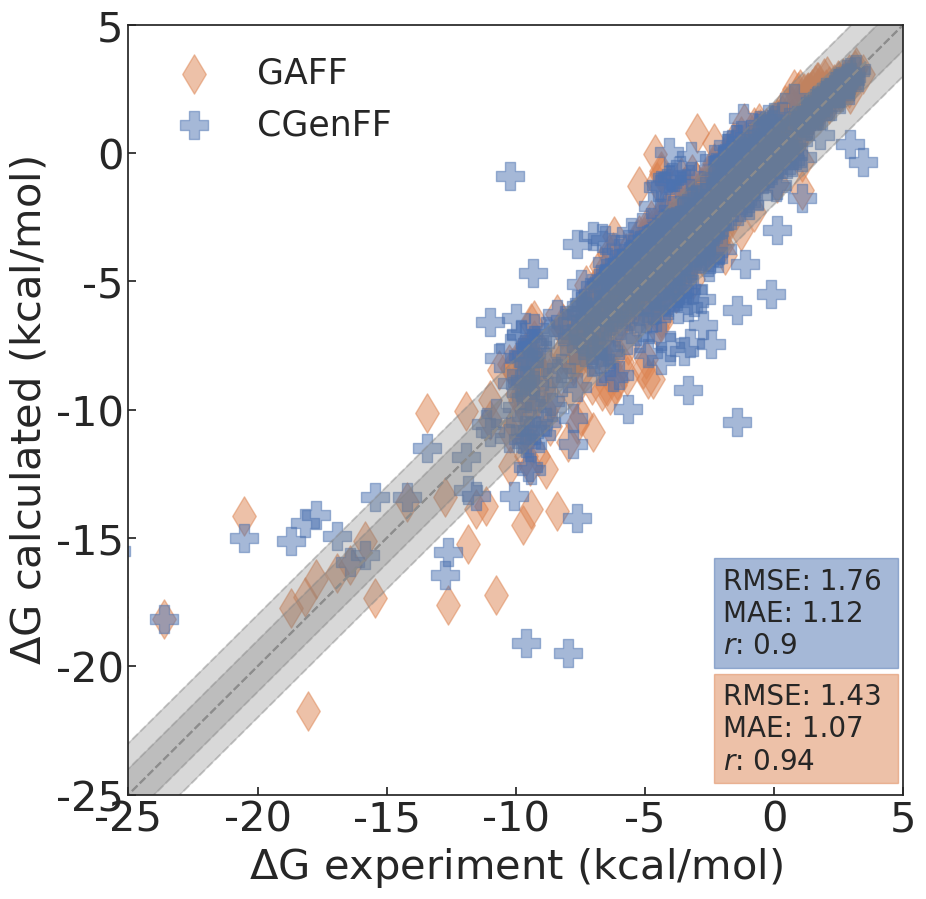

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

x = data[" experimental value (kcal/mol)"]
mobley = data[" Mobley group calculated value (GAFF) (kcal/mol)"]
tf = data["dG (TF) lrc"]
# axs.errorbar(
#     x,
#     mobley,
#     xerr=data[" experimental uncertainty (kcal/mol)"],
#     linestyle="",
#     yerr=data[" calculated uncertainty (kcal/mol)"],
#     label="GAFF",
#     marker="d",
#     alpha=0.5,
#     color="C1",
# )
# axs.errorbar(
#     x,
#     tf,
#     label="CGenFF",
#     xerr=data[" experimental uncertainty (kcal/mol)"],
#     yerr=data["std (TF)"],
#     linestyle="",
#     marker="P",
#     alpha=0.5,
#     color="C0",
# )
axs.scatter(x, mobley, label="GAFF", marker="d", alpha=0.5, color="C1")
axs.scatter(x, tf, label="CGenFF", marker="P", alpha=0.5, color="C0")


plotting_grey_area(0, one_plot=True)
axs.set_xlim([-25, 5])
axs.set_ylim([-25, 5])
axs.set_xlabel("$\Delta$G experiment (kcal/mol)")
axs.set_ylabel("$\Delta$G calculated (kcal/mol)")
plt.legend(frameon=False)

rmse, mae, r, _, _  = calculate_statistics(x,tf)
text = f'RMSE: {rmse} \nMAE: {mae} \n$r$: {r}'
axs.text(-2,-19.5, text , fontsize=20, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'C0', 'ec': 'C0', 'alpha': 0.5})

rmse, mae, r, _, _  = calculate_statistics(x,mobley)
text = f'RMSE: {rmse} \nMAE: {mae} \n$r$: {r}'
axs.text(-2,-24, text , fontsize=20, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'C1', 'ec': 'C1', 'alpha': 0.5})


plt.savefig("images/overview_charmm_vs_gaff.pdf")

In [9]:
# data_reduced = data.dropna(subset=["dG (Brooks)"])
# print(len(data_reduced))

In [10]:
# print(f"##### Statistics for TF vs experiment #####")
# calculate_statistics(data_reduced[" experimental value (kcal/mol)"],data_reduced["dG (TF)"])
# print(f"##### Statistics for Brooks vs experiment #####")
# calculate_statistics(data_reduced[" experimental value (kcal/mol)"],data_reduced["dG (Brooks)"])
# print(f"###################################")
# print(f"##### Statistics TF vs Brooks #####")
# calculate_statistics(data_reduced["dG (TF)"],data_reduced["dG (Brooks)"])

In [11]:
# fig, axs = plt.subplots(1,1, figsize=(10, 10))

# x = data["dG (TF)"]
# brooks = data["dG (Brooks)"]

# axs.scatter(x,brooks, alpha = 0.8, color = "C0")

# plotting_grey_area(0, one_plot=True)
# axs.set_xlim([-20,5])
# axs.set_ylim([-20,5])
# axs.set_xlabel("$\Delta$G TF (kcal/mol)")
# axs.set_ylabel("$\Delta$G Brooks (kcal/mol)")
# plt.legend(frameon=False)

In [12]:
my_cols = [
    "id",
    "iupac",
    "group1",
    "group2",
    "group3",
    "group4",
    "group5",
    "group6",
    "group7",
]
groups = pd.read_csv(
    "https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/groups.txt",
    delimiter=";",
    names=my_cols,
    skiprows=1,
)
groups["group1"] = groups["group1"].str.strip()
groups["iupac"] = groups["iupac"].str.strip()

In [13]:
### For some reasons all alkane are not belonging to any group
groups.loc[groups["iupac"] == "hydrogen sulfide", "iupac"] = "thiol (sulfanyl)"
groups.loc[groups["iupac"] == "ammonia", "iupac"] = "others"
groups.loc[groups["group1"] == "", "group1"] = "alkane"

In [14]:
groups.loc[:, "exp"] = np.nan
groups.loc[:, "exp TF"] = np.nan
groups.loc[:, "calc GAFF"] = np.nan
groups.loc[:, "calc TF"] = np.nan

for index, row in groups.iterrows():
    for index2, row2 in data.iterrows():
        if row["id"] == row2["# compound id (and file prefix)"]:
            groups.loc[index, "calc GAFF"] = row2[
                " Mobley group calculated value (GAFF) (kcal/mol)"
            ]
            groups.loc[index, "exp"] = row2[" experimental value (kcal/mol)"]

            if not np.isnan(row2["dG (TF)"]):
                groups.loc[index, "calc TF"] = row2["dG (TF) lrc"]
                groups.loc[index, "exp TF"] = row2[" experimental value (kcal/mol)"]

comb = groups.groupby("group1", as_index=False)[["exp", "calc GAFF"]].agg(
    lambda x: list(x)
)
comb = comb.dropna(axis=0)

comb_tf = groups.groupby("group1", as_index=False)[["exp TF", "calc TF"]].agg(
    lambda x: list(x)
)
comb_tf = comb_tf.dropna(axis=0)

In [15]:
### Sort Data according to the functional group

# data.loc[:, "functional group"] = np.nan

# for index, row in data.iterrows():
#     for index2, row2 in groups.iterrows():
#         if row["# compound id (and file prefix)"].strip() == row2["id"]:
#             data.loc[index, "functional group"] = row2["group1"]

In [16]:
def calculate_stats_per_row(x, y):
    rmse = np.sqrt(mean_squared_error(x, y))
    mae = mean_absolute_error(x, y)
    r = scipy.stats.pearsonr(x, y)[0]

    return rmse, mae, r

In [17]:
def create_df(df, x_name, y_name):
    df.loc[:, "rmse"] = np.nan
    df.loc[:, "mae"] = np.nan
    df.loc[:, "r"] = np.nan
    df.loc[:, "number"] = np.nan

    for index, row in df.iterrows():
        x = row[x_name]
        y = row[y_name]
        x = [a for a in x if str(a) != "nan"]
        y = [a for a in y if str(a) != "nan"]
        if len(x) == len(y) and len(x) > 11:
            rmse, mae, r = calculate_stats_per_row(x, y)
            df.loc[index, "rmse"] = rmse
            df.loc[index, "mae"] = mae
            df.loc[index, "r"] = r
            df.loc[index, "number"] = len(x)

    return df


comb = create_df(comb, "exp", "calc GAFF")
comb_tf = create_df(comb_tf, "exp TF", "calc TF")

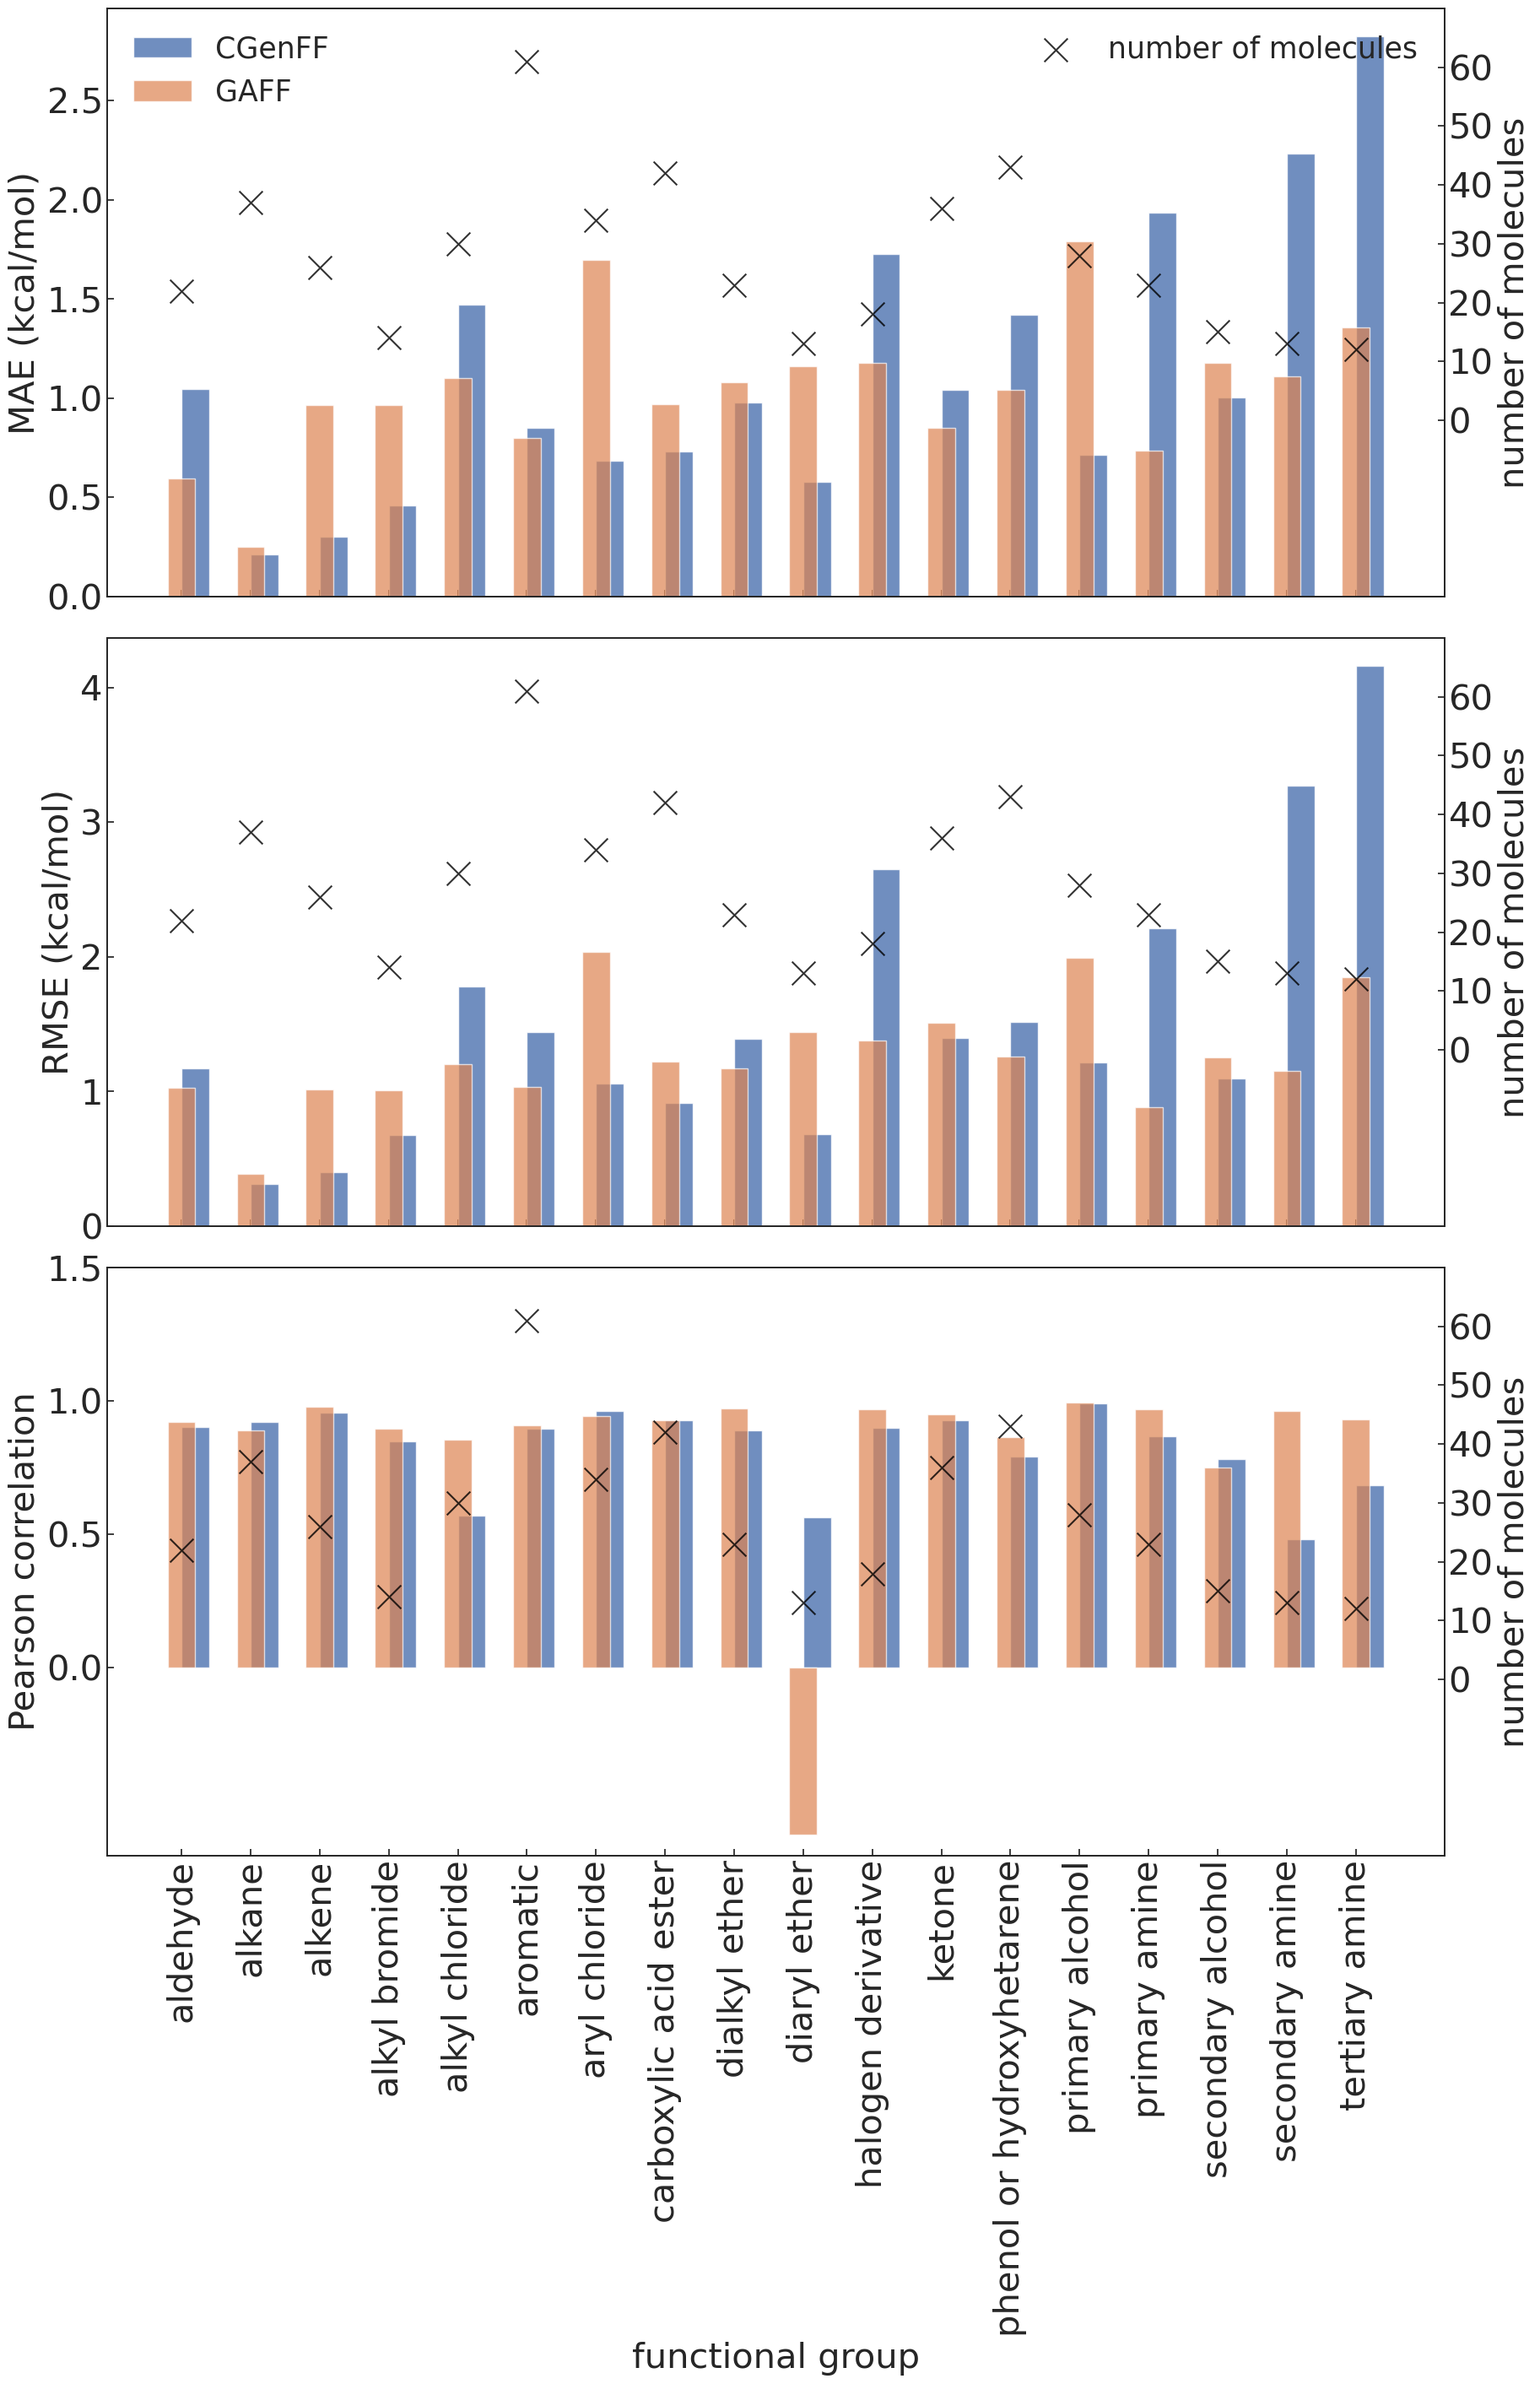

In [18]:
# sns.set_theme(style='white', rc={'figure.figsize': (10,10),'axes.unicode_minus': False,'axes.labelsize': 15.0, 'font.size': 40, 'legend.fontsize': 15, 'lines.markersize': 10,'xtick.labelsize': 15,'ytick.labelsize': 15, 'ytick.direction': "in"})

fig, ax = plt.subplots(3, 1, figsize=(20, 30), sharex=True)
fig.subplots_adjust(hspace=0.02, wspace=0.05)
fig.autofmt_xdate(rotation=90, ha="center")


######## Mean Absolute Error ##############
comb_tf = comb_tf.dropna(axis=0)
ax[0].bar(
    comb_tf["group1"],
    comb_tf["mae"],
    alpha=0.8,
    align="edge",
    width=0.4,
    label="CGenFF",
)

comb = comb.dropna(axis=0)  # remove all nan
ax[0].bar(comb["group1"], comb["mae"], alpha=0.7, width=0.4, label="GAFF")

# Second axis
ax2 = ax[0].twinx()
ax2.scatter(
    comb["group1"],
    comb["number"],
    color="black",
    label="number of molecules",
    marker="x",
    alpha=0.8,
)
ax2.set_ylabel("number of molecules")

ax[0].legend(frameon=False, loc="upper left")
ax2.legend(frameon=False)

ax2.set_yticks(np.arange(-30, 80, 10))
ax2.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax[0].set_ylabel("MAE (kcal/mol)")

######## Root mean squared Error ##############
comb_tf = comb_tf.dropna(axis=0)
ax[1].bar(
    comb_tf["group1"],
    comb_tf["rmse"],
    alpha=0.8,
    align="edge",
    width=0.4,
    label="CGenFF",
)

comb = comb.dropna(axis=0)  # remove all nan
ax[1].bar(comb["group1"], comb["rmse"], alpha=0.7, width=0.4, label="GAFF")

# Second axis
ax2 = ax[1].twinx()
ax2.scatter(
    comb["group1"],
    comb["number"],
    color="black",
    label="number of molecules",
    marker="x",
    alpha=0.8,
)
ax2.set_ylabel("number of molecules")

ax2.set_yticks(np.arange(-30, 80, 10))
ax2.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax[1].set_ylabel("RMSE (kcal/mol)")

######## Pearson correlation ##############
comb_tf = comb_tf.dropna(axis=0)
ax[2].bar(
    comb_tf["group1"], comb_tf["r"], alpha=0.8, align="edge", width=0.4, label="CGenFF"
)

comb = comb.dropna(axis=0)  # remove all nan
ax[2].bar(comb["group1"], comb["r"], alpha=0.7, width=0.4, label="GAFF")

# Second axis
ax2 = ax[2].twinx()
ax2.scatter(
    comb["group1"],
    comb["number"],
    color="black",
    label="number of molecules",
    marker="x",
    alpha=0.8,
)
ax2.set_ylabel("number of molecules")

ax2.set_yticks(np.arange(-30, 80, 10))
ax2.set_yticks([0, 10, 20, 30, 40, 50, 60])
ax[2].set_yticks(np.arange(0, 2, 0.5))
ax[2].set_ylabel("Pearson correlation")


ax[2].set_xlabel("functional group")
plt.tight_layout(h_pad=0.1)
plt.savefig("images/functional_groups_hist.pdf")

In [19]:
from openbabel import openbabel
from openbabel import pybel

# Ensure comparison only where TF results are available
data = data.dropna(subset=["dG (TF) lrc"])

# Iterate over dataframe and create a key (number of atoms)
# where the corresponding dG either from TF or from GAFF
# are saved
calc_tf = dict()
calc_gaff = dict()
exp = dict()

for index, row in data.iterrows():
    smiles = row[" SMILES"]
    name = row["# compound id (and file prefix)"]

    mol = pybel.readstring("smi", smiles.strip())

    numAtoms = len(mol.atoms)

    try:
        calc_tf[numAtoms].append(row["dG (TF) lrc"])

        calc_gaff[numAtoms].append(
            row[" Mobley group calculated value (GAFF) (kcal/mol)"]
        )

        exp[numAtoms].append(row[" experimental value (kcal/mol)"])

    except KeyError:
        calc_tf[numAtoms] = []
        calc_tf[numAtoms].append(row["dG (TF) lrc"])

        calc_gaff[numAtoms] = []
        calc_gaff[numAtoms].append(
            row[" Mobley group calculated value (GAFF) (kcal/mol)"]
        )

        exp[numAtoms] = []
        exp[numAtoms].append(row[" experimental value (kcal/mol)"])

In [20]:
def calculate_mae_with_error(x_values, y_values):
    # bootstrap MAE
    mae_mean, mae_lower, mae_upper = bootstrap_metric(
        mean_absolute_error, x_values, y_values
    )
    # print(f"MAE:  {round(mae_mean, 2)} [{round(mae_lower,2)}, {round(mae_upper,2)}]")

    return (
        round(mae_mean, 2),
        round(mae_lower, 2),
        round(mae_upper, 2),
    )

In [21]:
# From the previously generated array, rmse is calculated and stored in a list
# the list is transformed to a np array
def create_array(dictonary, lst):
    for i in sorted(dictonary.keys()):
        if len(dictonary[i]) > 3:
            mae, lower, upper = calculate_mae_with_error(exp[i], dictonary[i])
            lst.append(
                [
                    int(i),
                    round(mae, 3),
                    round(lower, 3),
                    round(upper, 3),
                ]
            )
    return lst


nr_tf = []
nr_gaff = []
nr_tf = create_array(calc_tf, nr_tf)
nr_gaff = create_array(calc_gaff, nr_gaff)

nr_tf = np.asarray(nr_tf)
nr_gaff = np.asarray(nr_gaff)

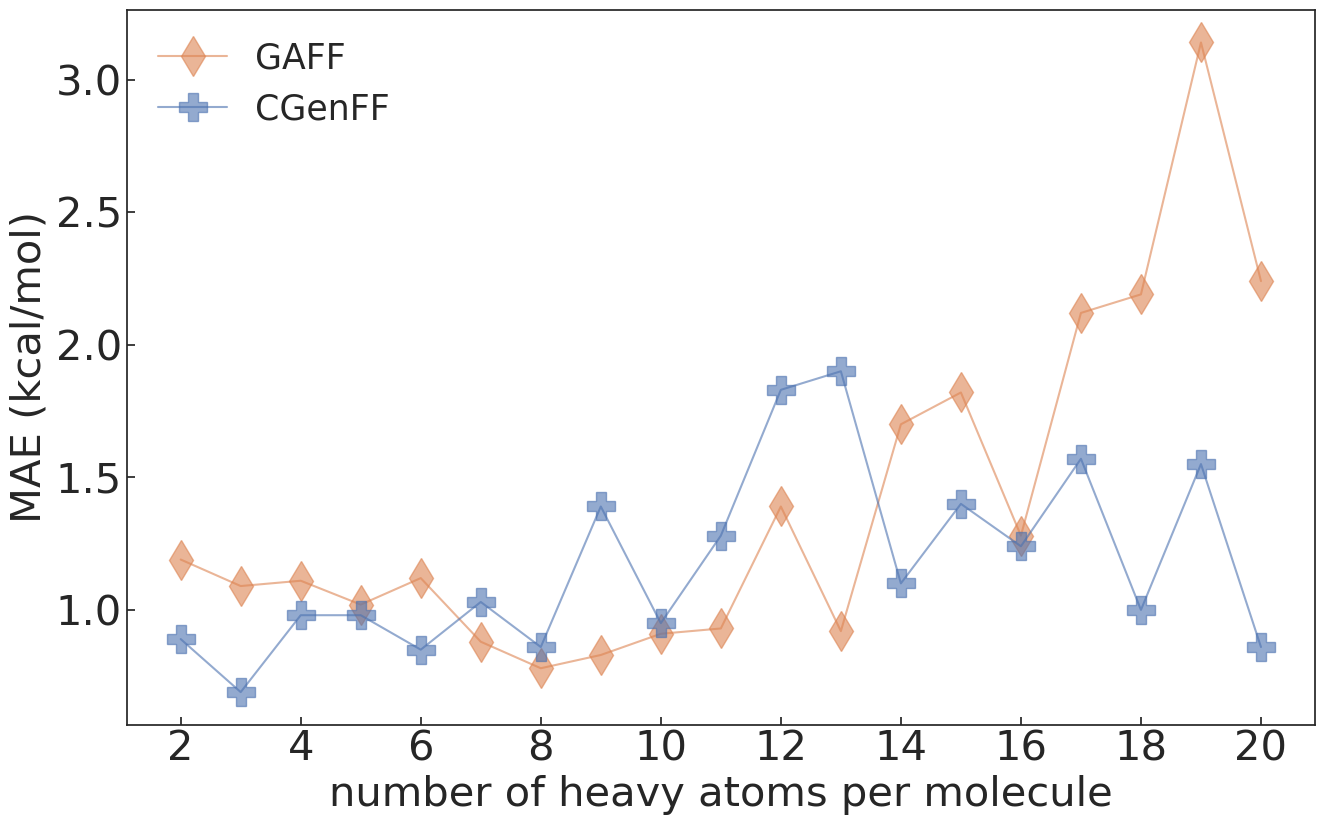

In [22]:
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.plot(nr_gaff[:, 0], nr_gaff[:, 1], alpha=0.6, marker="d", color="C1", label="GAFF")
# ax1.fill_between(nr_gaff[:, 0], nr_gaff[:, 2], nr_gaff[:, 3], color="C1", alpha=0.1)

ax1.plot(nr_tf[:, 0], nr_tf[:, 1], alpha=0.6, marker="P", color="C0", label="CGenFF")
# ax1.fill_between(nr_tf[:, 0], nr_tf[:, 2], nr_tf[:, 3], color="C0", alpha=0.1)


ax1.set_ylabel("MAE (kcal/mol)")
ax1.set_xlabel("number of heavy atoms per molecule")
# ax1.set_yticks(np.arange(0,5))
ax1.set_xticks(np.arange(2, 21, 2))
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.savefig("images/atoms_per_molecule.pdf")

In [23]:
groups.loc[:, "GAFF"] = np.nan
groups.loc[:, "CGenFF"] = np.nan

for index, row in groups.iterrows():
    for index2, row2 in data.iterrows():
        if row["id"] == row2["# compound id (and file prefix)"]:
            groups.loc[index, "GAFF"] = np.abs(
                row2[" Mobley group calculated value (GAFF) (kcal/mol)"]
                - row2[" experimental value (kcal/mol)"]
            )

            if not np.isnan(row2["dG (TF) lrc"]):
                groups.loc[index, "CGenFF"] = np.abs(
                    row2["dG (TF) lrc"] - row2[" experimental value (kcal/mol)"]
                )

comb = groups.groupby("group1", as_index=False)[["exp", "calc GAFF"]].agg(
    lambda x: list(x)
)
comb = comb.dropna(axis=0)

comb_tf = groups.groupby("group1", as_index=False)[["exp TF", "calc TF"]].agg(
    lambda x: list(x)
)
comb_tf = comb_tf.dropna(axis=0)

groups_calc = groups[["GAFF", "CGenFF"]]
melted = groups_calc.reset_index().melt(
    id_vars="index", var_name="Force Field", value_name="MAE"
)
melted = pd.merge(melted, groups, left_on="index", right_index=True)
# melted = melted.reset_index()
counts = melted["group1"].value_counts()
melted = melted[melted["group1"].isin(counts.index[counts >= 23])]

In [24]:
# melted = melted[melted["group1"].str.contains("alkyl chloride|halogen derivative|dialkyl ether|tertiary amine") == False]

In [25]:
labeling = melted.groupby("group1")["exp"].count()
labeling = labeling / 2

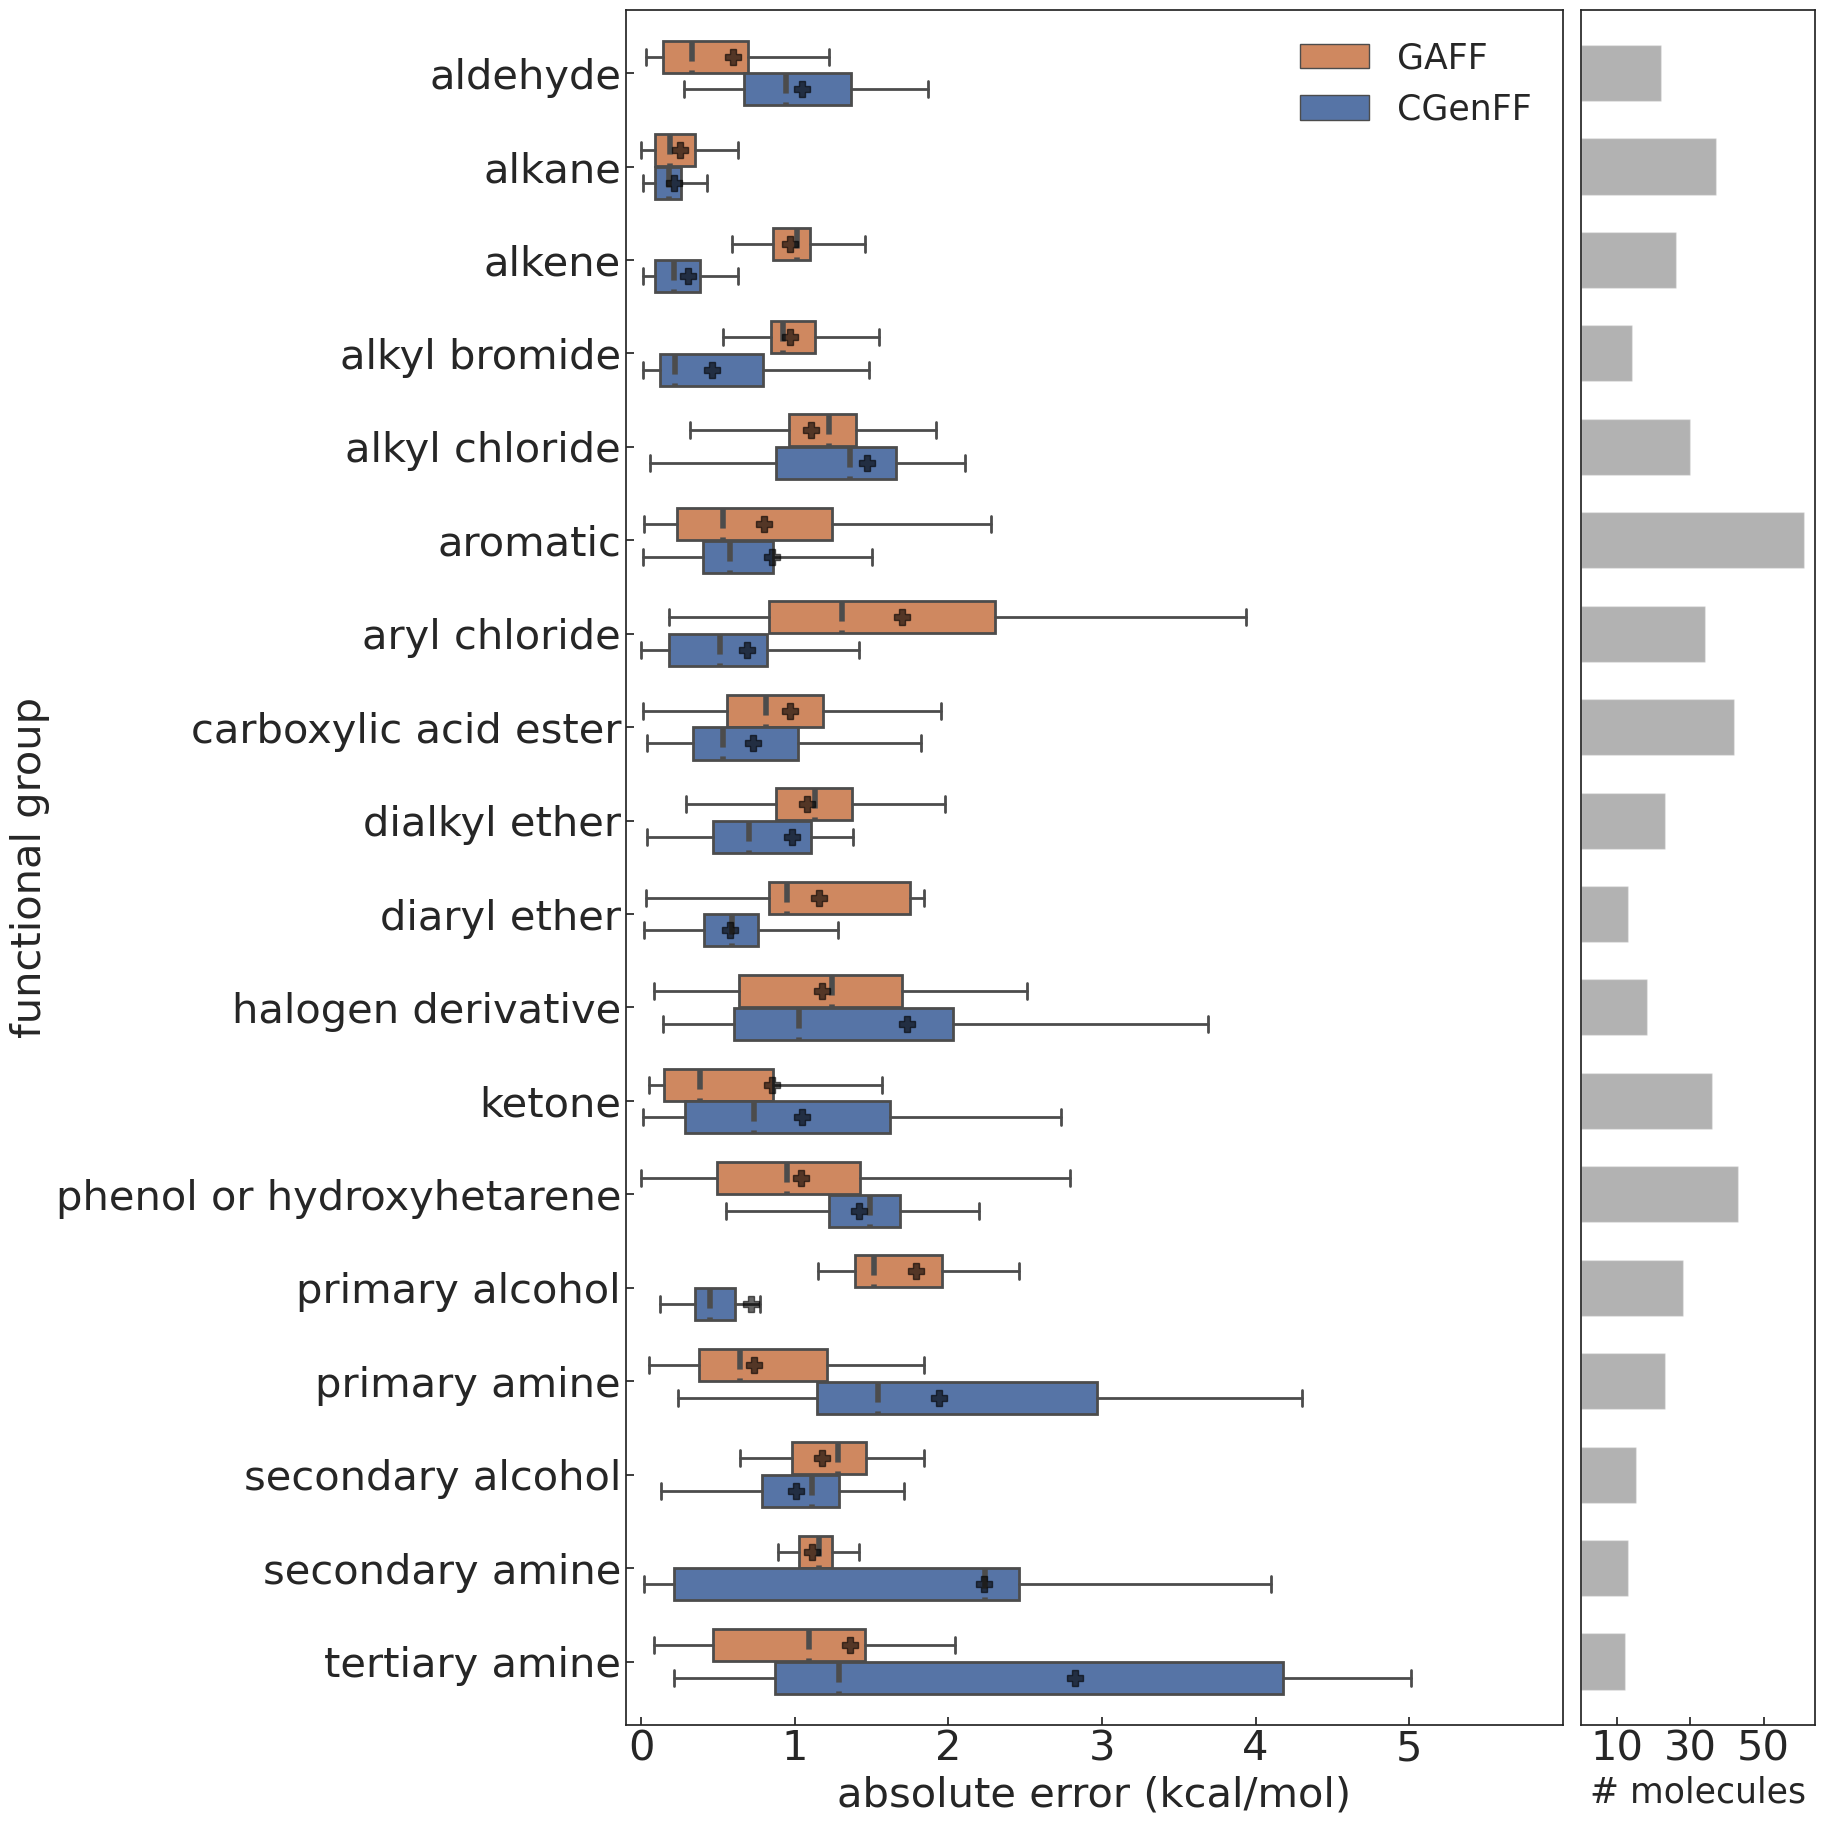

In [26]:
fig, ax = plt.subplots(
    1, 2, figsize=(20, 20), sharey=True, gridspec_kw={"width_ratios": [4, 1]}
)
# fig.autofmt_xdate(rotation=90, ha = "center")
fig.subplots_adjust(hspace=0.05, wspace=0.05)
# ax = ax.ravel()

meanprops = dict(
    marker="P",
    markeredgecolor="black",
    markerfacecolor="black",
    markersize=12,
    alpha=0.6,
)
medianprops = dict(linewidth=4, linestyle="--")
flierprops = dict(
    marker="o",
    markerfacecolor="r",
    markersize=12,
    linestyle="none",
    markeredgecolor="g",
)
sns.boxplot(
    data=melted,
    y="group1",
    x="MAE",
    hue="Force Field",
    ax=ax[0],
    width=0.7,
    medianprops=medianprops,
    showmeans=True,
    meanprops=meanprops,
    order=labeling.index,
    saturation=0.8,
    linewidth=2,
    palette={"GAFF": "C1", "CGenFF": "C0"},
    fliersize=12,
    orient="h",
    showfliers=False,
)

ax[1].barh(
    width=labeling,
    y=labeling.index,
    height=0.6,
    alpha=0.3,
    color="black",
    label="number \n of \n molecules",
)

# from matplotlib.patches import Rectangle
# from matplotlib.pyplot import cm
# import matplotlib
# cmap = cm.gray_r
# bar = ax[1].barh(width=labeling,y=labeling.index,height=0.7, color = "white",label ="number \n of \n molecules")
# max_value = max(bar.datavalues)
# num_segments = 100
# segment_width = max_value/num_segments
# for rect in bar.get_children():
#     height = rect.get_height()
#     width = rect.get_width()
#     # width = rect.get_height()
#     # height = rect.get_width()
#     y = rect.get_y()
#     segment_positions = np.arange(0, width, segment_width)
#     for i, segment_position in enumerate(segment_positions):
#         color = cmap(segment_position/max_value)
#         start = i * segment_width
#         end = start + segment_width
#         if end > width:
#             end = width
#         rec = Rectangle((segment_position,y),end-start,height, color=color)
#         ax[1].add_patch(rec)


# ax[1].scatter(y = labeling.index,x=labeling, color = "black" ,marker="s",label ="number \n of \n molecules", alpha = 0.4)


ax[1].set_xticks(np.arange(0, 60, 10))
ax[1].set_xticks([10, 30, 50])
ax[1].set_xlabel("# molecules", fontsize=25, loc="center")
# ax[1].set_xlabel("number of molecules")
ax[1].tick_params(left=False)


ax[0].legend(frameon=False, loc="upper right")
ax[0].set_xlim([-0.1, 6])
ax[0].set_xticks([0, 1, 2, 3, 4, 5])
ax[0].set_ylabel("functional group")
ax[0].set_xlabel("absolute error (kcal/mol)")
plt.tight_layout(w_pad=0.2)
plt.savefig("images/functional_groups_box.pdf")

In [39]:
subset = pd.read_csv(
    "https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/subset.csv",
    header=1,
)

In [40]:
# subset = subset[0:22]

def reduce_df(df, column1, column2):
    for index, row in df.iterrows():
        if np.isnan(row[column1]):
            df = df.drop(index, axis=0)
    for index, row in df.iterrows():
        if np.isnan(row[column2]):
            df = df.drop(index, axis=0)
    return df

##################
Wieder vs TF
RMSE:  0.81 [0.36, 1.15]
MAE:  0.49 [0.16, 0.88]
Pearson correlation:  0.98 [0.95, 1.0]
Spearman's correlation:  0.98 [0.85, 1.0]
Kendalltau: 0.92 [0.74, 1.0]
##################
Fleck vs TF
RMSE:  0.51 [0.09, 0.87]
MAE:  0.23 [0.08, 0.5]
Pearson correlation:  0.99 [0.97, 1.0]
Spearman's correlation:  0.98 [0.89, 1.0]
Kendalltau: 0.92 [0.78, 1.0]


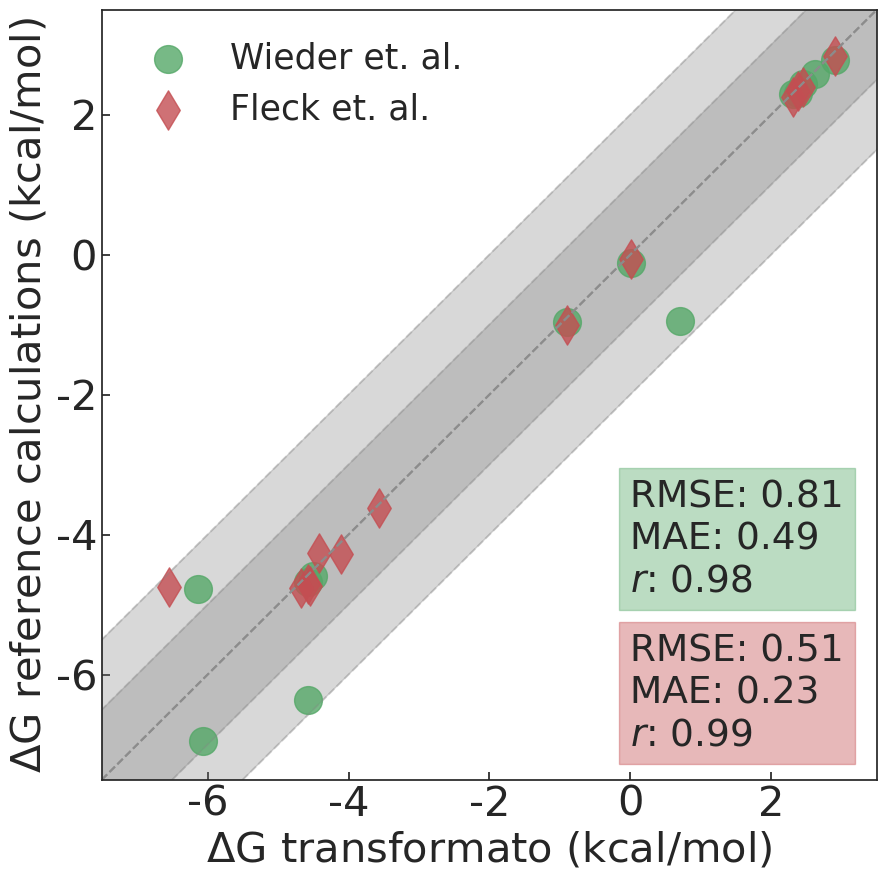

In [29]:
fig, axs = plt.subplots(figsize=(10, 10))


i = 0
plotting_grey_area(0, one_plot=True)
axs.set_xlim([-7.5, 3.5])
axs.set_ylim([-7.5, 3.5])
axs.set_xlabel("$\Delta$G transformato (kcal/mol)")
axs.set_ylabel("$\Delta$G reference calculations (kcal/mol)")

x = "ref_dG (TF)"
y = "ref_wieder"

print("##################")
print("Wieder vs TF")
df = reduce_df(subset, x, y)
rmse, mae, r, _, _ = calculate_statistics(df[x], df[y])

axs.scatter(subset[x], subset[y], color="C2", label="Wieder et. al.", alpha=0.8)
text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -4.8,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "C2", "ec": "C2", "alpha": 0.4},
)

y = "ref_fleck"

print("##################")
print("Fleck vs TF")
df2 = reduce_df(subset, x, y)
rmse, mae, r, _, _ = calculate_statistics(df2[x], df2[y])

axs.scatter(
    subset[x], subset[y], marker="d", color="C3", label="Fleck et. al.", alpha=0.8
)
text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -7,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "C3", "ec": "C3", "alpha": 0.4},
)

axs.legend(frameon=False)

plt.savefig("images/comparison_charmm_pure.pdf")

RMSE:  0.21 [0.14, 0.28]
MAE:  0.16 [0.11, 0.22]
Pearson correlation:  1.0 [1.0, 1.0]
Spearman's correlation:  0.99 [0.93, 1.0]
Kendalltau: 0.94 [0.83, 1.0]


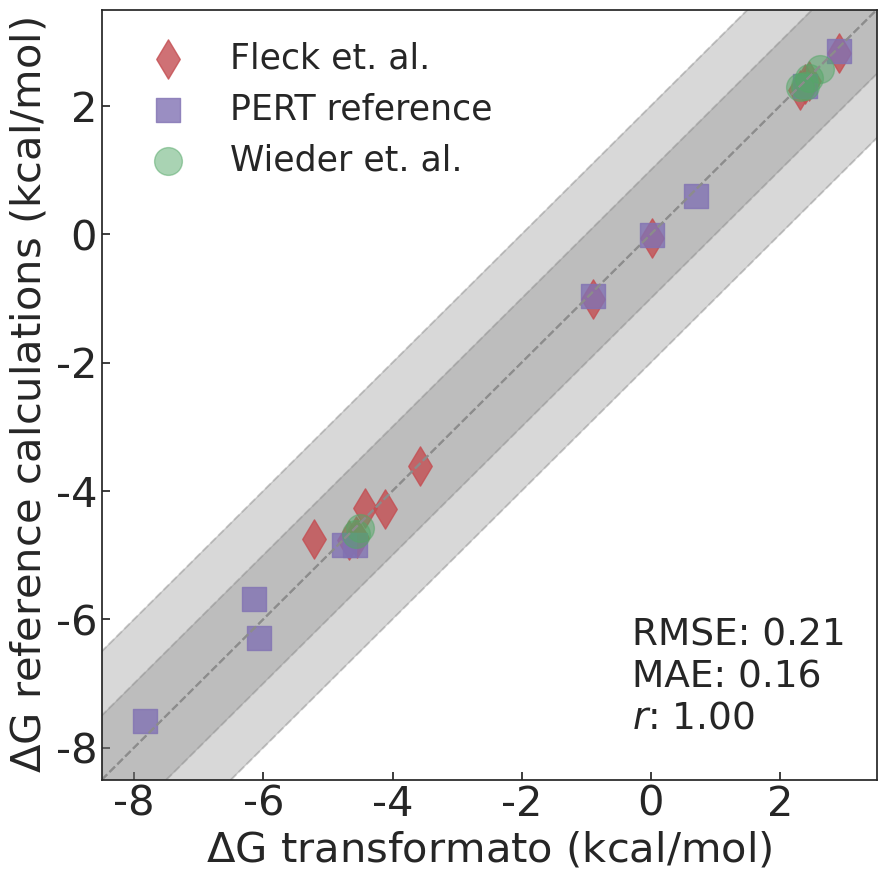

In [30]:
fig, axs = plt.subplots(figsize=(10, 10))

i = 0

plotting_grey_area(0, one_plot=True)
axs.set_xlim([-8.5, 3.5])
axs.set_ylim([-8.5, 3.5])
axs.set_xlabel("$\Delta$G transformato (kcal/mol)")
axs.set_ylabel("$\Delta$G reference calculations (kcal/mol)")

x = "cor_dG (TF)"

y = "cor_fleck"

axs.scatter(
    subset[x], subset[y], marker="d", color="C3", label="Fleck et. al.", alpha=0.8
)


y = "cor_stefan"
axs.scatter(
    subset[x],
    subset[y],
    marker="s",
    s=300,
    color="C4",
    label="PERT reference",
    alpha=0.8,
)

y = "cor_wieder"

axs.scatter(subset[x], subset[y], color="C2", label="Wieder et. al.", alpha=0.5)

### Values for statistics of all reference values ###
y = "cor_charmm"
df4 = reduce_df(subset, x, y)
rmse, mae, r, _, _ = calculate_statistics(df4[x], df4[y])
text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    -0.3,
    -7.7,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": False, "fc": "Grey", "alpha": 0.},
)  # 'ec': 'Grey',

axs.legend(frameon=False)

plt.savefig("images/comparison_charmm_cleaned.pdf")

OpenMM switch vs experiment
RMSE:  2.66 [0.72, 4.42]
MAE:  1.35 [0.62, 2.6]
Pearson correlation:  0.87 [0.8, 0.99]
Spearman's correlation:  0.97 [0.87, 1.0]
Kendalltau: 0.88 [0.74, 0.98]
vfswitch vs experiment
RMSE:  0.98 [0.66, 1.34]
MAE:  0.85 [0.61, 1.13]
Pearson correlation:  0.98 [0.96, 1.0]
Spearman's correlation:  0.96 [0.81, 1.0]
Kendalltau: 0.87 [0.7, 1.0]


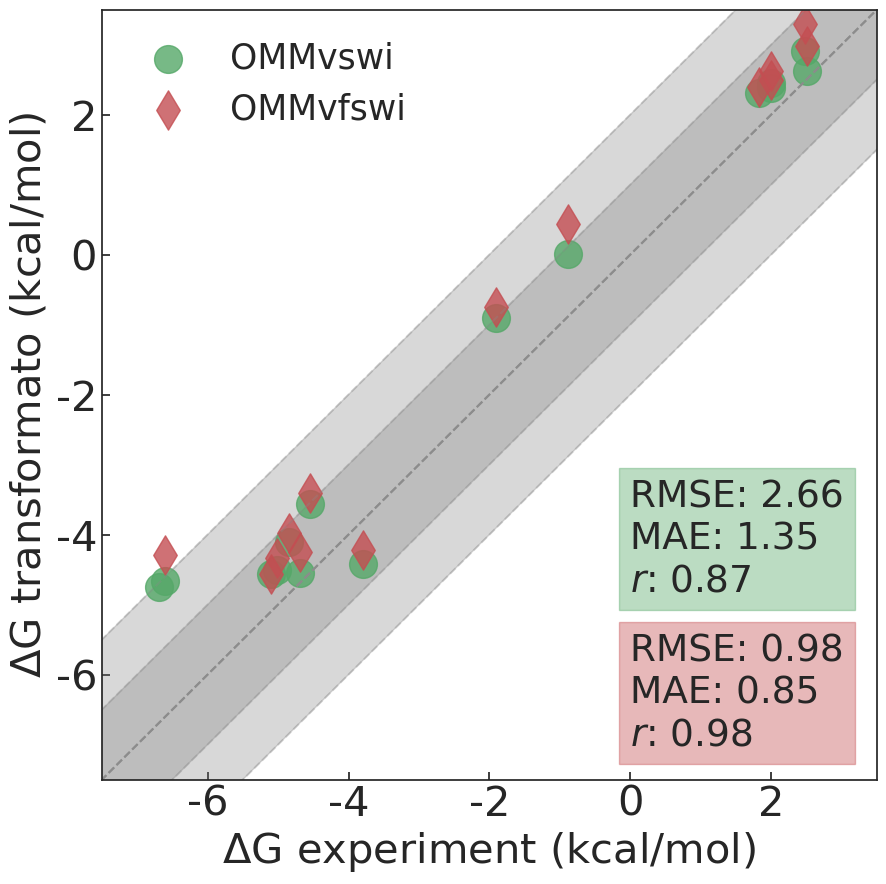

In [31]:
fig, axs = plt.subplots(figsize=(10, 10))


i = 0
plotting_grey_area(0, one_plot=True)
axs.set_xlim([-7.5, 3.5])
axs.set_ylim([-7.5, 3.5])
axs.set_xlabel("$\Delta$G experiment (kcal/mol)")
axs.set_ylabel("$\Delta$G transformato (kcal/mol)")


x = "exp"

print("OpenMM switch vs experiment")
y = "cor_dG (TF) switch"
df = reduce_df(subset[0:22], x, y)
# df = df[:-3]  ## ATTENTION, we have to remove the values where ther is no analogon in vfswitch
rmse, mae, r, _, _ = calculate_statistics(df[x], df[y])

axs.scatter(subset[x][0:22], subset[y][0:22], color="C2", label="OMMvswi", alpha=0.8)
text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -4.8,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "C2", "ec": "C2", "alpha": 0.4},
)

print("vfswitch vs experiment")
y = "vfswitch dG (TF)"
df2 = reduce_df(subset[0:22], x, y)
rmse, mae, r, _, _ = calculate_statistics(df2[x], df2[y])

axs.scatter(
    subset[x][0:22], subset[y][0:22], marker="d", color="C3", label="OMMvfswi", alpha=0.8
)
text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -7,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "C3", "ec": "C3", "alpha": 0.4},
)

axs.legend(frameon=False)
plt.savefig(f"images/comparison_switching_exp.pdf")

RMSE:  0.36 [0.23, 0.48]
MAE:  0.29 [0.21, 0.38]
Pearson correlation:  1.0 [1.0, 1.0]
Spearman's correlation:  0.96 [0.82, 1.0]
Kendalltau: 0.88 [0.7, 1.0]


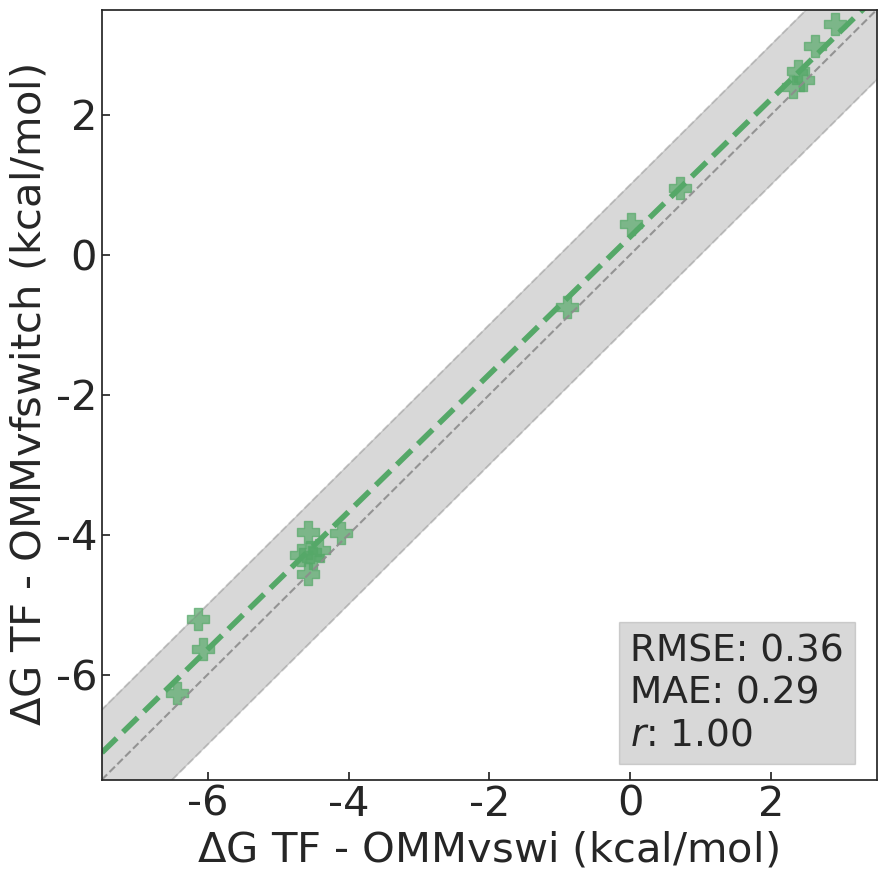

In [43]:
fig, axs = plt.subplots(figsize=(10, 10))

x = np.linspace(-30, 20, 5)
y = x
axs.plot(x, y, alpha=0.9, color="C7", linestyle="dashed")
y2 = x + 1
axs.plot(x, y2, alpha=0.3, color="C7", linestyle="dashed")
y3 = x - 1
axs.plot(x, y3, alpha=0.3, color="C7", linestyle="dashed")
axs.fill_between(x, y2, y3, alpha=0.3, color="Grey")

i = 0
# plotting_grey_area(0, one_plot=True)
axs.set_xlim([-7.5, 3.5])
axs.set_ylim([-7.5, 3.5])
axs.set_xlabel("$\Delta$G TF - OMMvswi (kcal/mol) ")
axs.set_ylabel("$\Delta$G TF - OMMvfswitch (kcal/mol)")

x = "cor_dG (TF) switch"
y = "vfswitch dG (TF)"

df = reduce_df(subset, x, y)
rmse, mae, r, _, _ = calculate_statistics(df[x], df[y])
# axs.scatter(subset[x],subset[y], color ="C2",s= 200,marker="P", alpha = 0.8)
text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -7,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "Grey", "ec": "Grey", "alpha": 0.3},
)

### Add regression line ###
sns.regplot(
    x=df[x].dropna().to_numpy()[0:18],
    y=df[y].dropna().to_numpy()[0:18],
    truncate=False,
    ci=None,
    scatter_kws={"s": 250, "alpha": 0.7},
    line_kws={"ls": "--", "lw": "4"},
    marker="P",
    color="C2",
)

plt.savefig(f"images/comparison_switching_regression.pdf")

TF vs LJPME
RMSE:  0.53 [0.41, 0.65]
MAE:  0.43 [0.31, 0.55]
Pearson correlation:  1.0 [1.0, 1.0]
Spearman's correlation:  1.0 [0.97, 1.0]
Kendalltau: 0.97 [0.92, 1.0]
TF LRC vs LJPME
RMSE:  0.17 [0.12, 0.22]
MAE:  0.12 [0.08, 0.17]
Pearson correlation:  1.0 [1.0, 1.0]
Spearman's correlation:  1.0 [0.99, 1.0]
Kendalltau: 0.99 [0.95, 1.0]


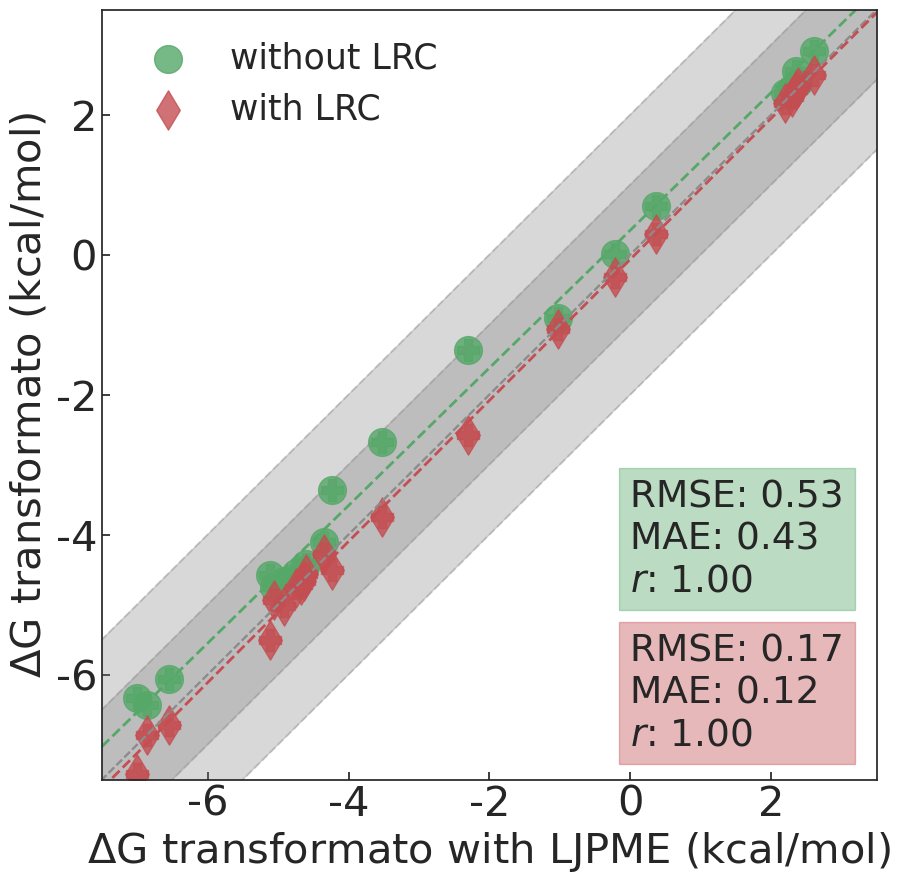

In [44]:
fig, axs = plt.subplots(figsize=(10, 10))


i = 0
plotting_grey_area(0, one_plot=True)
axs.set_xlim([-7.5, 3.5])
axs.set_ylim([-7.5, 3.5])
axs.set_xlabel("$\Delta$G transformato with LJPME (kcal/mol)")
axs.set_ylabel("$\Delta$G transformato (kcal/mol)")


x = "dG (TF) LJPM switch"

print("TF vs LJPME")
y = "cor_dG (TF) switch"
df = reduce_df(subset, x, y)
# df = df[:-3]  ## ATTENTION, we have to remove the values where ther is no analogon in vfswitch
rmse, mae, r, _, _ = calculate_statistics(df[x], df[y])

axs.scatter(subset[x], subset[y], color="C2", label="without LRC", alpha=0.8)

### Add regression line ###
sns.regplot(
    x=df[x].dropna().to_numpy(),
    y=df[y].dropna().to_numpy(),
    truncate=False,
    ci=None,
    scatter_kws={"s": 250, "alpha": 0.7},
    line_kws={"ls": "--", "lw": "2"},
    marker="P",
    color="C2",
)

text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -4.8,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "C2", "ec": "C2", "alpha": 0.4},
)

print("TF LRC vs LJPME")
y = "dG (TF) lrc switch"
df2 = reduce_df(subset, x, y)
rmse, mae, r, _, _ = calculate_statistics(df2[x], df2[y])

axs.scatter(
    subset[x], subset[y], marker="d", color="C3", label="with LRC", alpha=0.8
)

## Add regression line ###
sns.regplot(
    x=df2[x].dropna().to_numpy(),
    y=df2[y].dropna().to_numpy(),
    truncate=False,
    ci=None,
    scatter_kws={"s": 250, "alpha": 0.7},
    line_kws={"ls": "--", "lw": "2"},
    marker="P",
    color="C3",
)

text = f"RMSE: {rmse}\nMAE: {mae}\n$r$: {r:.2f}"
axs.text(
    0,
    -7,
    text,
    fontsize=27,
    bbox={"boxstyle": "square", "fill": True, "fc": "C3", "ec": "C3", "alpha": 0.4},
)

axs.legend(frameon=False)
plt.savefig(f"images/comparison_LJPME_LRC.pdf")

In [34]:
from cairosvg import svg2png
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from transformato import load_config_yaml

## Draw all molecules as image
subset = subset[0:18]

name = []
smiles = []
for i, smi in enumerate(subset["smiles"]):
    if smi == smi:
        smiles.append(smi)
        name.append(subset["iupac"][i])

name.append("acetic acid ")  # \n Mobley ID:2725215
smiles.append("CC(=O)O")
name.append("2-[(1R)-1-methylpropyl]-4,6-dinitro-phenolate ")  # \n Mobley ID: 3274817
smiles.append("CC[C@@H](C)c1cc(cc(c1O)[N+](=O)[O-])[N+](=O)[O-]")
name.append("nitralin ")  # \n Mobley ID: 2725215
smiles.append("CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])S(=O)(=O)C)[N+](=O)[O-]")

ms = [Chem.MolFromSmiles(x) for x in smiles]

# IPythonConsole.drawOptions.baseFontSize = 5
IPythonConsole.drawOptions.explicitMethyl = True
IPythonConsole.drawOptions.fixedFontSize = 15
IPythonConsole.drawOptions.legendFontSize = 35


img = Draw.MolsToGridImage(
    ms, subImgSize=(250, 250), molsPerRow=6, legends=name, returnPNG=True
)
img

svg2png(bytestring=img.data, write_to=f"images/initialRound.png")

In [35]:
lrc_full_tests = pd.read_csv(
    "https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/lrc_full_tests.csv"
)

In [36]:
lrc_full_tests = lrc_full_tests[:-6]

[category.py:234 - update()] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[category.py:234 - update()] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[category.py:234 - update()] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[category.py:234 - update()] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[category.py:234 - update()] Using categorical units to plot a list of strings that are all parsable as floats or dates. If 

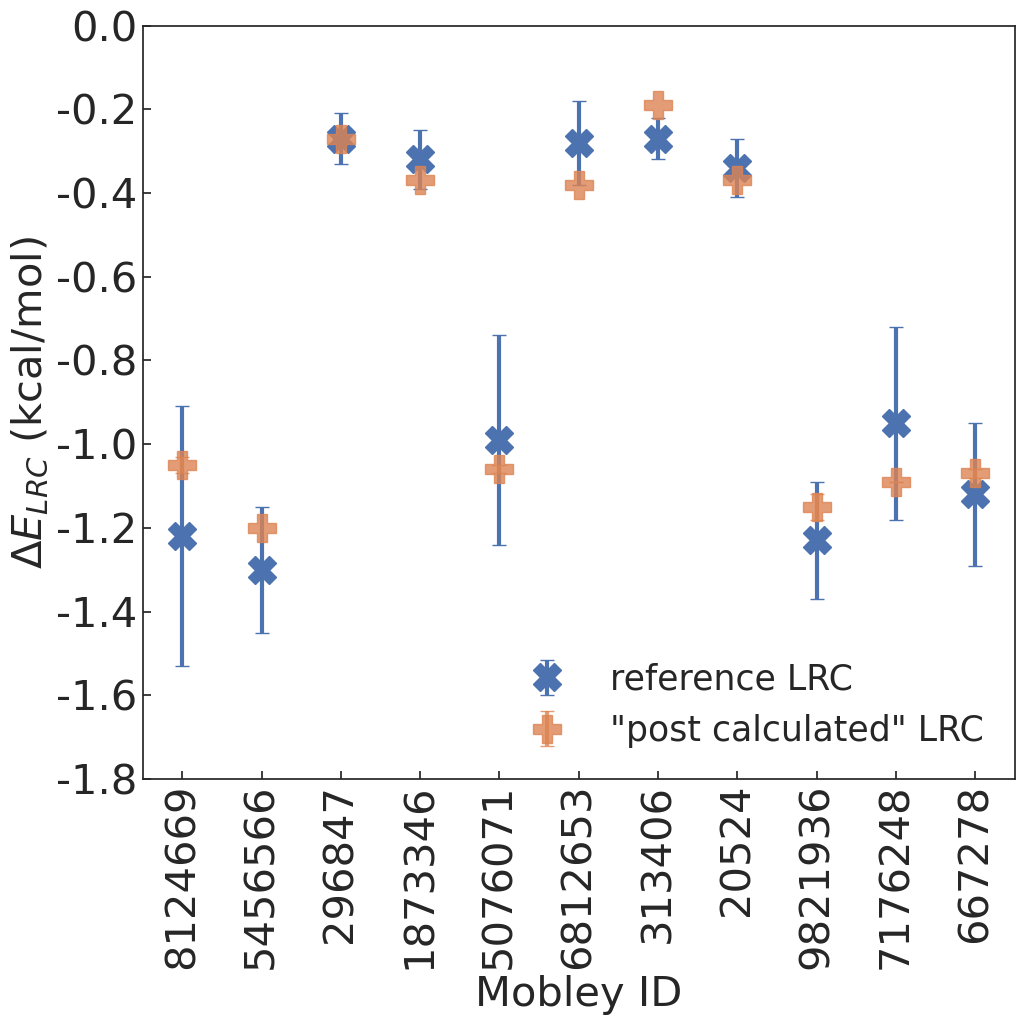

In [37]:
fig, axs = plt.subplots(figsize=(12, 12))
fig.autofmt_xdate(rotation=90, ha="center")

axs.errorbar(
    lrc_full_tests["mobley_id"].astype(str),
    lrc_full_tests["reference LRC"],
    marker="X",
    linestyle="",
    yerr=lrc_full_tests["error"],
    ecolor="C0",
    capsize=5,
    label="reference LRC",
    elinewidth=3
)
# plt.scatter(lrc_full_tests["mobley_id"].astype(str),lrc_full_tests["dG (TF LRC)"])

axs.errorbar(
    lrc_full_tests["mobley_id"].astype(str),
    lrc_full_tests["preCalc LRC"],
    linestyle="",
    marker="P",
    alpha=0.8,
    label='"post calculated" LRC',
    yerr=lrc_full_tests["error Pre"],
    ecolor="C1",
    capsize=5,
    elinewidth=3,
)

plt.ylim([-1.8,0])
plt.legend(frameon=False,loc="lower right")
plt.xlabel("Mobley ID")
plt.ylabel("$\Delta E_{LRC}$ (kcal/mol)")

plt.tight_layout()
plt.savefig("images/lrc_subset.pdf")

In [45]:
subset

,iupac,dG (TF),smiles,exp,cor_fleck,cor_stefan,cor_wieder,cor_charmm,cor_dG (TF),cor_dG (TF) switch,cor std (TF),ref_fleck,ref_wieder,ref_charmm,ref_dG (TF),ref std (TF),vfswitch dG (TF),Unnamed: 17,dG (TF) lrc switch,dG (TF) LJPM switch
0,methane,2.42,C,1.99,2.39,NaN,2.431,2.431,2.45,2.45,0.03,2.39,2.431,2.431,2.45,0.03,2.50,0.05,2.39,2.38
1,ethane,2.27,CC,1.83,2.25,NaN,2.294,2.294,2.31,2.31,0.05,2.25,2.294,2.294,2.31,0.05,2.40,0.09,2.17,2.20
2,ethanol,-4.49,CCO,-5.01,NaN,NaN,-4.585,-4.585,-4.51,-4.51,0.05,NaN,-4.585,-4.585,-4.51,0.05,-4.34,0.17,-4.67,-4.63
3,methanol,-4.63,CO,-5.10,-4.70,NaN,-4.676,-4.676,-4.57,-4.57,0.03,-4.70,-4.676,-4.676,-4.57,0.03,-4.57,0.00,-4.72,-4.67
4,neopentane,2.63,CC(C)(C)C,2.51,NaN,NaN,2.573,2.573,2.62,2.62,0.03,NaN,2.573,2.573,2.62,0.03,2.98,0.36,2.35,2.35
5,toluene,0.04,Cc1ccccc1,-0.89,-0.06,-0.02,NaN,-0.020,0.01,0.01,0.05,-0.06,-0.122,-0.122,0.01,0.05,0.43,0.42,-0.32,-0.22
6,2-methylfuran,0.70,CC1=CC=CO1,NaN,NaN,0.59,NaN,0.590,0.70,0.70,0.02,NaN,-0.943,-0.943,0.70,0.02,0.95,0.25,0.30,0.36
7,2-methyl-1H-indole,-6.07,CC1=CC2=CC=CC=C2N1,NaN,NaN,-6.30,NaN,-6.300,-6.07,-6.07,0.10,NaN,-6.949,-6.949,-6.07,0.10,-5.63,0.44,-6.72,-6.55
8,2-cyclopentylindole,NaN,C1CCCC1c2cc3ccccc3[nH]2,NaN,NaN,-5.69,NaN,-5.690,-6.14,-6.14,0.09,NaN,-4.783,-4.783,-6.14,0.09,-5.20,0.94,NaN,NaN
9,7-cyclopentylindole,-4.58,C1=CC=C(C2=C1C=C[nH]2)C3CCCC3,NaN,NaN,-4.85,NaN,-4.850,-4.58,-4.58,0.11,NaN,-6.367,-6.367,-4.58,0.11,-3.96,0.62,-5.50,-5.12
